In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import coo_matrix
import pickle
import sys 

path = '/fit_netflix/ml/low_rank'

sys.path.append(path)

In [2]:
data = pickle.load(open('/data/movie_tables.pkl','rb'))
ratings_df = data['ratings_df']
ratings_val_df = data['ratings_val_df']
ratings_test_df = data['ratings_test_df']
val_keep = (ratings_val_df['userId'].isin(ratings_df['userId'])) & (ratings_val_df['movieId'].isin(ratings_df['movieId']))
test_keep = (ratings_test_df['userId'].isin(ratings_df['userId'])) & (ratings_test_df['movieId'].isin(ratings_df['movieId']))
ratings_val_df = ratings_val_df[val_keep]
ratings_test_df = ratings_test_df[test_keep]



In [3]:
from typing import Optional
from scipy.stats import rv_discrete
from util import rectangular_partition_train_val_test
from netflix import solver_params, wrap_mse_experiments

full_df = pd.concat([ratings_df, ratings_val_df, ratings_test_df], axis=0)
R = coo_matrix((full_df['rating'], (full_df['userId'],full_df['movieId'])))
R = np.asarray(R.todense())

train_p = .5
val_p = .3
n_row = R.shape[0]
n_col = R.shape[1]
Omegas = rectangular_partition_train_val_test(n_row, n_col, train_p, val_p)

X = (R > 0).astype(float)

p_solvers = solver_params()
print(len(p_solvers))

wrap_mse_experiments(X, Omegas, p_solvers)
#wrap_experiments(X, Omegas, p_solvers[:3])

  0%|          | 0/12 [00:00<?, ?it/s]

12


100%|██████████| 12/12 [14:25<00:00, 72.14s/it]


['netflix_mse_v5.solver_5_0.003000_200_0.010000_0',
 'netflix_mse_v5.solver_5_0.003000_200_0.010000_1',
 'netflix_mse_v5.solver_5_0.001000_200_0.010000_0',
 'netflix_mse_v5.solver_5_0.001000_200_0.010000_1',
 'netflix_mse_v5.solver_10_0.003000_200_0.010000_0',
 'netflix_mse_v5.solver_10_0.003000_200_0.010000_1',
 'netflix_mse_v5.solver_10_0.001000_200_0.010000_0',
 'netflix_mse_v5.solver_10_0.001000_200_0.010000_1',
 'netflix_mse_v5.solver_100_0.003000_200_0.010000_0',
 'netflix_mse_v5.solver_100_0.003000_200_0.010000_1',
 'netflix_mse_v5.solver_100_0.001000_200_0.010000_0',
 'netflix_mse_v5.solver_100_0.001000_200_0.010000_1']

In [4]:
from itertools import product

from tqdm import tqdm
from util import load_obj
#netflix_logistic_v3.solver_5_0.001000_200_0.010000_0_obj.pkl
Res = {}
for apsolver in tqdm(p_solvers):
    name = "_".join(['netflix_mse', apsolver._str()])
    Res[apsolver] = load_obj(name)


100%|██████████| 12/12 [00:00<00:00, 14.80it/s]


In [5]:
import pandas as pd
from mc import GDSolverParam
import numpy as np
import matplotlib.pyplot as plt


def to_frame(_psolver, _res, idx_tag="0"):
    _res = _res.copy()
    _res.pop("U")
    _res.pop("V")
    _res.pop('test_top')
    _df = pd.DataFrame(_res)
    stat_cols = list(_df.columns)
    _df["estk"] = _psolver.estk
    _df["lr"] = _psolver.lr
    _df["scale_init"] = _psolver.scale_init
    _df["seed"] = _psolver.random_seed
    _df["idx_tag"] = idx_tag
    _df["iters"] = list(range(_df.shape[0]))
    solver_cols = ["estk", "lr", "scale_init", "iters", "seed"]
    cols = solver_cols + stat_cols + ["idx_tag"]
    return _df[cols]



def build_opt_p(use_solvers, res_map):
    df_m = pd.concat(
        [
            to_frame(aps, res_map[aps], i)
            for i, aps in tqdm(enumerate(use_solvers), disable=True)
        ],
        axis=0,
        ignore_index=True,
    )

    # find the optimal one
    df_m = df_m[df_m["iters"] % 10 == 9]
    #idx = df_m["val_loss"].argmin()
    idx = df_m["val_loss"].argmin()
    res = {}
    res2 = {
        "estk": df_m.iloc[idx, :].estk,
        "lr": df_m.iloc[idx, :].lr,
        "scale_init": df_m.iloc[idx, :].scale_init,
        "train_loss": df_m.iloc[idx, :].train_loss,
        "train_misclass": df_m.iloc[idx, :].train_misclassify,
        'val_loss': df_m.iloc[idx, :].val_loss,
        'val_misclass': df_m.iloc[idx, :].val_misclassify,
        'test_loss': df_m.iloc[idx, :].test_loss,
        'test_misclass': df_m.iloc[idx, :].test_misclassify,
        "seed": df_m.iloc[idx, :].seed,
        "iters": df_m.iloc[idx, :].iters,
        "n_iter": 200,
    }

    # find the result using the last iteration.
    idx_tag = df_m.iloc[idx, :].idx_tag
    stopped_cor = df_m[df_m.idx_tag == idx_tag].iloc[-1, :].test_loss
    if stopped_cor < 0 or stopped_cor <= df_m.iloc[idx, :].test_loss * 0.9:
        res2["early_stop"] = True
    else:
        res2["early_stop"] = False

    res.update(res2)
    rrr = pd.DataFrame(res, index=[0])

    use_solver = GDSolverParam(
        estk=res2["estk"],
        lr=res2["lr"],
        scale_init=res2["scale_init"],
        n_iter=res2["n_iter"],
        random_seed=res2["seed"],
    )
    use_iter = int(df_m.iloc[idx, :].iters)

    useU = Res[use_solver]["U"][use_iter // 10]
    useV = Res[use_solver]["V"][use_iter // 10]
    
    estG = useU @ useV.T
    
    avg_estG = estG.copy()
    solvers_with_other_seeds = [
        GDSolverParam(
            estk=res2["estk"],
            lr=res2["lr"],
            scale_init=res2["scale_init"],
            n_iter=res2["n_iter"],
            random_seed=i,
        )
        for i in range(2)
        if i != res2["seed"]
    ]
    all_cors = []
    all_pred_corr = []
    ii = 1
    
    for tmp in solvers_with_other_seeds:
        if tmp in Res:
            all_cors.append(Res[tmp]["test_loss"][use_iter])
            nextU = Res[tmp]["U"][use_iter // 10]
            nextV = Res[tmp]["V"][use_iter // 10]
            nextG = nextU@(nextV.T)
            avg_estG += nextG
            ii += 1
            predcor = np.corrcoef((nextG).reshape(-1), estG.reshape(-1))
            all_pred_corr.append(predcor[0, 1])

    mean_corr = np.mean(all_cors)
    mean_predcorr = np.mean(all_pred_corr)
    
    rrr["mean_loss"] = mean_corr
    rrr["pred_corr"] = mean_predcorr
    #rrr['improved_corr'] = np.corrcoef(raw_data['latent'].reshape(-1), avg_estG.reshape(-1))[0, 1]
    return rrr



res = Res[p_solvers[0]]
dft = to_frame(p_solvers[0], res)

#plt.figure()
#dft['train_loss'].plot()
#plt.figure()
#dft['test_misclassify'].plot()

In [6]:
use_solvers = [p_solver for p_solver in p_solvers if p_solver.random_seed == 0]

df_merged = pd.concat([build_opt_p([solver], Res) for solver in tqdm(use_solvers)], axis=0)
df_merged


100%|██████████| 6/6 [00:00<00:00,  8.72it/s]


,estk,lr,scale_init,train_loss,train_misclass,val_loss,val_misclass,test_loss,test_misclass,seed,iters,n_iter,early_stop,mean_loss,pred_corr
0,5.0,0.003,0.01,0.016690,0.020882,0.018650,0.022438,0.018854,0.022804,0.0,89.0,200,False,0.019075,0.922923
0,5.0,0.001,0.01,0.017905,0.022275,0.018991,0.022785,0.019193,0.023071,0.0,199.0,200,False,0.019095,0.977839
0,10.0,0.003,0.01,0.016203,0.020305,0.018448,0.022330,0.018638,0.022671,0.0,79.0,200,False,0.018621,0.956943
0,10.0,0.001,0.01,0.017173,0.021493,0.018669,0.022614,0.018873,0.022947,0.0,199.0,200,False,0.018841,0.976232
0,100.0,0.003,0.01,0.011863,0.015093,0.017709,0.021483,0.017869,0.021833,0.0,79.0,200,False,0.017830,0.967282
0,100.0,0.001,0.01,0.013809,0.017990,0.017874,0.021898,0.018027,0.022228,0.0,199.0,200,False,0.018038,0.979907


In [7]:
print(df_merged[['estk', 'lr', 'train_loss', 'test_loss', 'test_misclass']].to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &   estk &     lr &  train\_loss &  test\_loss &  test\_misclass \\
\midrule
0 &    5.0 &  0.003 &    0.016690 &   0.018854 &       0.022804 \\
0 &    5.0 &  0.001 &    0.017905 &   0.019193 &       0.023071 \\
0 &   10.0 &  0.003 &    0.016203 &   0.018638 &       0.022671 \\
0 &   10.0 &  0.001 &    0.017173 &   0.018873 &       0.022947 \\
0 &  100.0 &  0.003 &    0.011863 &   0.017869 &       0.021833 \\
0 &  100.0 &  0.001 &    0.013809 &   0.018027 &       0.022228 \\
\bottomrule
\end{tabular}



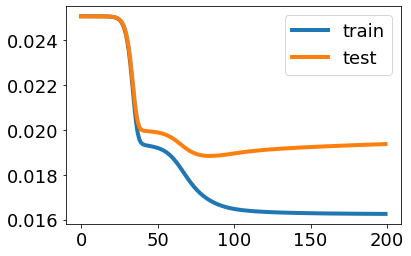

In [8]:
fontsize=18
plt.plot(Res[p_solvers[0]]['train_loss'], label='train', linewidth=4)
plt.plot(Res[p_solvers[0]]['test_loss'], label='test', linewidth=4)
plt.legend(loc="upper right", fontsize=fontsize )
plt.tick_params(axis="both", which="major", labelsize=fontsize)
plt.savefig('mse.png')